# 앙상블 학습 및 랜덤포레스트

## 앙상블 학습
- 정의
    > 여러 개의 모델을 결합하여 더 나은 예측 성능을 얻는 방법론
    - 하나의 좋은 모델을 사용하는 것 대신 여러 예측기로 부터 예측을 수집하는 것

# 1. 투표 기반 분류기
## 직접 투표 분류기
- 각 분류기의 예측 집계 후 다수결 투표로 예측을 결정
- 앙상블이 있는 `약한 학습기`가 `강한 학습기`가 될 수 있음 (큰 수의 법칙)
    - `약한 학습기` : 랜덤 추측보다 조금 더 나은 성능을 보이는 분류기
    - `강한 학습기` : 랜덤 추측보다 훨씬 더 나은 성능을 보이는 분류기

### 직접 투표 분류기의 가정/단점
- 모든 분류기가 완벽하게 독립 + 오차에 상관관계가 없어야함
- 동일한 데이터로 훈련시키는 경우 X

### 사이킷런을 통한 직접 투표 분류기 구현
- `VotingClassifier` 사용
- 원본 추정기에 대한 속성은 `named_estimators_(딕셔너리)` 혹은 `estimator_` 속성에 저장됨

#### 예시
- `moons`데이터셋 사용
- 로지스틱 선형회귀, 랜덤포레스트, SVC 모델 사용


In [7]:
from ensurepip import bootstrap

from lightgbm import early_stopping
from numpy.ma.core import remainder
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingRegressor, \
    HistGradientBoostingClassifier, HistGradientBoostingRegressor, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC

### 데이터셋 생성
X,y = make_moons(n_samples=500, noise=0.3, random_state=42)

### 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 직접 투표 분류기 생성
voting_clf = VotingClassifier(
    estimators=[
        ### 로지스틱 회귀
        ('lr', LogisticRegression(random_state=42)),
        ### 랜덤 포레스트
        ('rf', RandomForestClassifier(random_state=42)),
        ### 서포트 벡터 머신
        ('svc', SVC(random_state=42))
    ]
)

### 모델 훈련
voting_clf.fit(X_train, y_train)

### 개별 모델의 정확도 출력
print("개별 모델의 정확도:")
for name, clf in voting_clf.named_estimators_.items():
    print(f"{name} accuracy: {clf.score(X_test, y_test):.2f}")

print("="*20)
### 앙상블 모델의 예측
print(f"첫 번째 샘플 예측 : {voting_clf.predict(X_test[:1])}")
print("="*20)
### 분류기 별 예측
print("각 분류기의 예측:")
for name, clf in voting_clf.named_estimators_.items():
    print(f"{name} 예측: {clf.predict(X_test[:1])}")

개별 모델의 정확도:
lr accuracy: 0.86
rf accuracy: 0.90
svc accuracy: 0.90
첫 번째 샘플 예측 : [1]
각 분류기의 예측:
lr 예측: [1]
rf 예측: [1]
svc 예측: [0]


- 테스트 세트에 대한 성능 확인
    - 개별 분류기의 성능 보다 높음

In [8]:
print("테스트 세트 정확도:", voting_clf.score(X_test, y_test))

테스트 세트 정확도: 0.912


## 간접 투표 방식
> 각 분류기의 예측 확률을 평균하여 최종 예측을 결정
  - 모든 분류기가 `클래스 확률 추정`이 가능해야만함 (=`predict_proba` 메서드가 있어야함)

- 장점 : 확률이 높은 투표에 비중을 두기 때문에 ==성능이 더 높음 ==

- 사이킷런에서 `VotingClassifier`의 `voting='soft'` 옵션을 사용하여 구현 가능
  - SVC는 클래스 확률 제공 X -> `probability=True` 옵션을 사용하여 확률 추정 가능

- 간접 투표 방식 예시

In [9]:
### 간접 투표 방식 설정
voting_clf.voting="soft"

### SVC의 확률 추정 가능하도록 설정
voting_clf.named_estimators['svc'].probability=True

### 모델 재훈련
voting_clf.fit(X_train, y_train)

### 테스트 세트 정확도 출력
print("테스트 세트 정확도 (간접 투표):", voting_clf.score(X_test, y_test))

테스트 세트 정확도 (간접 투표): 0.92


# 2. 배깅과 페이스팅
> 같은 알고리즘을 사용해 훈련 세트의 서브셋을 랜덤으로 구성하는 방식

## 정의
- `배깅` : 중복을 허용하여 샘플링
  - 같은 훈련 샘플을 여러 번 샘플링 할 수 있음
- `페이스팅` : 중복을 허용하지 않는 샘플링


## 예측 방법
- 배깅과 페이스팅의 예측 값
    - `분류` : 통계적 최빈값
    - `회귀` : 평균값
- `집계 함수`를 통과하면 `편향`과 `분산`이 모두 `감소`
  - 개별 예측기의 예측은 다소 편향 되어 있음
  - 앙상블의 결과는 `편향`은 유지되지만 `분산`이 감소함

- 예측기를 동시에 `병렬`로 수행 가능

## 사이킷런과 배깅 / 페이스팅 구현
### 클래스
- `BaggingClassifier` : `분류`기용 배깅
- `BaggingRegressor` : `회귀`용 배깅
    - 페이스팅의 경우 `bootstrap=False`로 설정

### 편향과 분산
- 배깅
    - 편향 : 약간 증가 (서브셋 다양성 추가)
    - 분산 : 감소 (예측기들의 상관관계 감소)

- 배깅 예시
  - 500개 샘플 중에서 100개 샘플을 사용
    - 결과 : 비슷한 편향에서 더 작은 분산을 만듦
        - 오차 수는 거의 동일 / 결정 경계가 덜 불규칙

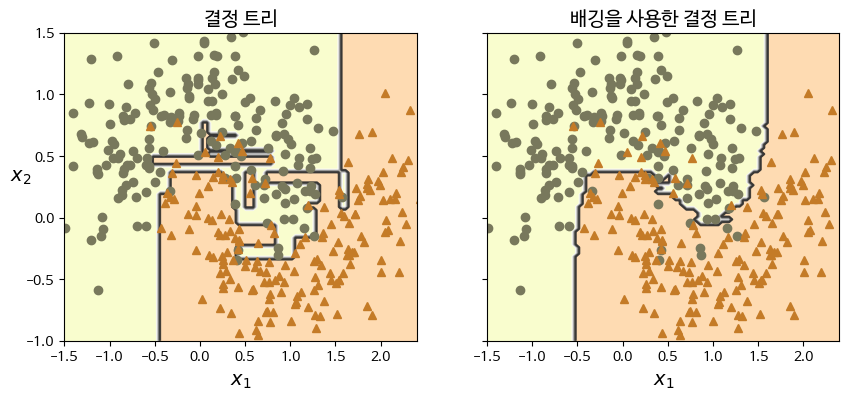

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500, ### 트리 수
                            max_samples=100, ### 사용 샘플 수
                            n_jobs=1, ### CPU 모두 사용
                            random_state=42)

### moons 데이터셋 사용
bag_clf.fit(X_train, y_train)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("결정 트리")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("배깅을 사용한 결정 트리")
plt.ylabel("")

plt.show()

## OBB 평가
> OBB(Out-of-Bag) : 훈련 세트에 샘플링 되지 않은 샘플
- 선택되지 않은 OBB샘플을 이용하여 별도의 검증 세트를 사용하지 않고 평가 진행
- `obb_score=True` 옵션을 사용하여 OBB 평가 가능
- `obb_score_` 속성에 OBB 평가 결과 저장됨

- 예시 :  obb 평가

In [19]:
from sklearn.metrics import accuracy_score
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)
print("OBB 평가 점수:", bag_clf.oob_score_)

y_pred = bag_clf.predict(X_test)
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

OBB 평가 점수: 0.896
테스트 세트 정확도: 0.92


- OOB 샘플에 대한 결정 함수 값 : `oob_decision_function_` 속성에 저장됨
- 예측기가 `predict_proba` 메서드를 제공하는 경우
  - OOB 샘플에 대한 클래스 확률 추정 가능

In [20]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

# 3. 랜덤 패치와 랜덤 서브스페이스
- `랜덤 패치` : 훈련 샘플의 서브셋을 무작위로 선택하여 훈련
- `랜덤 서브스페이스` : 훈련 샘플의 전체를 사용하고, 특성의 서브셋을 무작위로 선택하여 훈련
- 편향 증가 하는대신 분산을 낮춤 m

# 4. 랜덤 포레스트
- 정의
    > 배깅과 랜덤 서브스페이스를 결합한 앙상블 학습 방법
- `랜덤 포레스트` : 배깅을 사용하여 여러 개의 결정 트리를 훈련시키고, 각 트리의 예측을 평균화하여 최종 예측을 생성
- 기본적으로 $\sqrt{n}$개의 특성 선택 -> 편향을 손해 보는 대신 분산을 낮춤
## 사이킷런에서 랜덤 포레스트 구현
### 클래스
- `RandomForestClassifier` : 분류용 랜덤 포레스트
- `RandomForestRegressor` : 회귀용 랜덤 포레스트
### 주요 매개변수
- `DecisionTree`의 트리를 제어하는 매개변수와 앙상블 학습을 위한 `BaggingClassifier` 매개변수를 모두 가짐
- `max_samples` : 훈련 샘플의 서브셋 크기

In [22]:
from sklearn.ensemble import RandomForestClassifier

### 랜덤 포레스트 분류기 생성
rnd_clf = RandomForestClassifier(
    n_estimators=500, # 트리 수
    max_leaf_nodes=16,  # 최대 리프 노드 수
    n_jobs=-1,  # 모든 CPU 사용
    random_state=42
)

### 모델 훈련
rnd_clf.fit(X_train, y_train)

### 예측 진행
y_pred = rnd_clf.predict(X_test)

### bagging을 이용한 Random Forest 구현
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt",
                           max_leaf_nodes=16, random_state=42),
    n_estimators=500,
    n_jobs=-1,
    random_state=42
)


## 엑스트라 트리
> 후보 특성을 사용해 랜덤으로 분할 후 최상의 분할을 선택하는 것처럼
> 트리에 극단적인 랜덤성을 추가한 것을 `익스트림 랜덤트리` 혹은 `엑트리라 트리` 라고 함

- `splitter="random"` 옵션을 사용하여 무작위로 분할
- `편향` 증가 , `분산` 감소
- `랜덤 포레스트`보다 더 빠르게 훈련됨

### 사이킷런 구현
- `ExtraTreesClassifier` : 분류용 엑스트림 랜덤 트리
- `ExtraTreesRegressor` : 회귀용 엑스트림 랜덤 트리
- `bootstrap`이 `False`로 설정되어 있어는 것을 제외하면 랜덤포레스트와 유사

## 특성 중요도
> 평균적으로 불순도를 얼마나 감소시키는지 측정하여 특성의 중요도를 평가 -> 특성 중요도
> (가중치 평균)
- 랜덤 포레스트의 장점 : 상대적 중요도 측정이 쉬움

- `feature_importances_` 속성을 사용하여 특성 중요도 확인 가능


- 예시) 붓꽃 데이터 셋을 사용하여 특성 중요도 확인

In [23]:
from sklearn.datasets import load_iris
### 붓꽃 데이터셋 로드
iris = load_iris(as_frame=True)
### 랜덤 포레스트 분류기 생성
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 random_state=42)
### 모델 학습
rnd_clf.fit(iris.data, iris.target)

### 특성 중요도 출력
for score, name in zip(rnd_clf.feature_importances_,iris.data.columns):
    print(f"{name}: {score:.2f}")

sepal length (cm): 0.11
sepal width (cm): 0.02
petal length (cm): 0.44
petal width (cm): 0.42


C:\ProgramData\miniconda3\envs\ml_basic\Lib\site-packages\sklearn\datasets\_openml.py:75: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


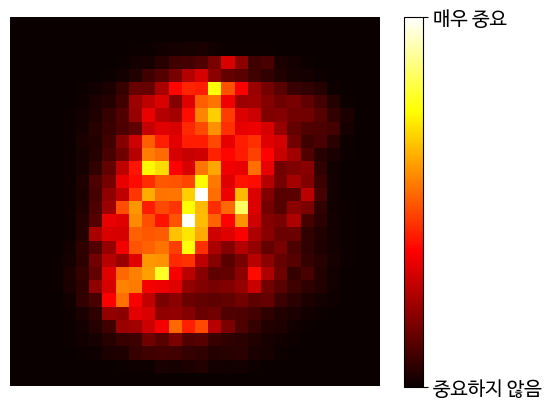

In [24]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis("off")
plt.show()

# 5. 부스팅
## 정의
> 약한 학습기를 순차적으로 훈련시키고, 이전 모델의 오차를 보완하는 방식
> 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

- 부스팅 종류
    - AdaBoost
    - Gradient Boosting

## AdaBoost

### 정의
> 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높임  -> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰짐
- 예측 후 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임 -> 업데이트된 가중치를 다시 훈련 후 예측
- 경사 하강법과 비슷한 면이 있음
- AdaBoost는 점차 더 좋아지도록 예측기를 추가
- 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다  다른 가중치가 적용

- 예시 : RBF 커널 SVM 모델
  - 잘못 훈련된 샘플의 가중치 증가 -> 잘못 분류된 샘플의 정확도 증가

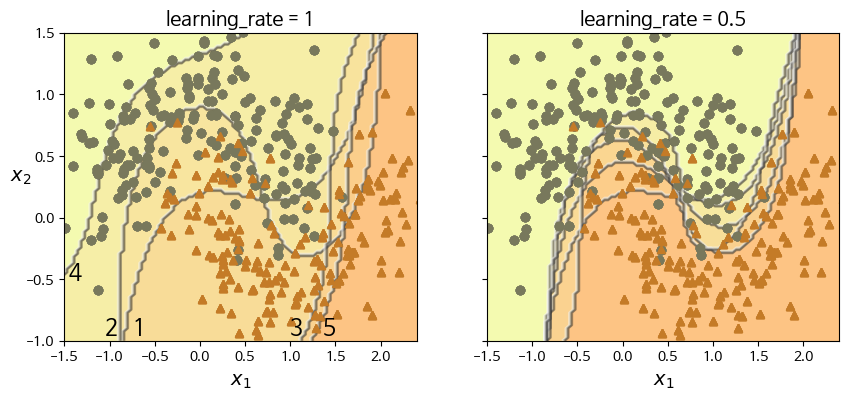

In [25]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

### AdaBoost 알고리즘
- 샘플 가중치 : $w^{(i)}$
  - 초기 가중치 : $w^{(i)} = \frac{1}{m}$ (m = 샘플 수)
  - 첫 학습 후 가중치가 적용된 오류율 $r_1$ 계산

#### 가중치 업데이트 :
$$
\begin{flalign}
r_j = \frac{\sum_{i=1}^{m} w^{(i)} \cdot I(\hat{y}^{(i)}_j \neq y^{(i)})}{\sum_{i=1}^{m} w^{(i)}} \\ &&
\end{flalign}
$$
- $\hat{y}^{(i)}_j$ : i번째 샘플에 대한 j번째 예측기의 예측

#### 예측기의 가중치 계산
$$
\begin{flalign}
\alpha_j = \eta \cdot \log\left(\frac{1 - r_j}{r_j}\right) &&
\end{flalign}
$$
- $\eta$ : 학습률 (기본 값 1)
    - 예측기가 정확할 수록 가중치가 높아짐
    - 랜덤할 수록 0에 가까워지고 결국은 음수가됨

#### 샘플 가중치 업데이트
- 잘 못 분류된 샘플의 가중치를 높인 후 가중치를 정규화
$$
\begin{flalign}
w^{(i)}  = \begin{cases}
\hat{y}_j^{(i)} = y^{(i)} \text{ 일 때,  }  w^{(i)}  \\
\hat{y}_j^{(i)} \neq y^{(i)} \text{ 일 때,  } \exp(\alpha_j))
\end{cases}
\end{flalign}
$$

#### 알고리즘의 중단
- 지정된 예측기 수의 도달
- 완벽한 예측기가 만들어진 경우
- 예측기의 예측을 계산하고 예측기 가중치를 더해 결과를 만듦 -> 가중치 합이 가증 큰 클래스가 예측결과가 됨

### 사이킷런 구현
- `AdaBoostClassifier` : 분류용 AdaBoost
- `AdaBoostRegressor` : 회귀용 AdaBoost
  - `SAMME` : 다중 클래스 분류를 위한 AdaBoost 알고리즘 기반
  - `SAMME.R` : 확률 추정 기반 AdaBoost 알고리즘

- 예시 : 결정트리 기반 깊이 200의 AdaBoost 분류기

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

## 그레디언트 부스팅
> 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 `잔여 오차`에 새로운 예측기를 훈련시키는 방식

- 예시 : GBRT
  - 2차 방정식 + 잡음 섞인 데이터셋
  - DecisionTreeRegressor 학습

In [30]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

### 랜덤 시드 설정
np.random.seed(42)

### 잡음을 추가한 데이터 생성
### y = 3x^2 + 가우스잡음
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

### 트리 생성
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)

### 첫 번째 트리 학습
tree_reg1.fit(X, y)

### 잔여 오차에 두 번째 트리 학습
### 잔여 오차
y2  =  y -tree_reg1.predict(X)
### 학습
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y)

### 두 번째 잔여 오차에 두 번째 트리 학습
### 잔여 오차
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y)

### 새로운 샘플 예측 생성
X_new = np.array([[-0.4], [0.], [0.5]])

### 각 트리별 예측 출력
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([1.46339046, 0.37069838, 1.58570538])

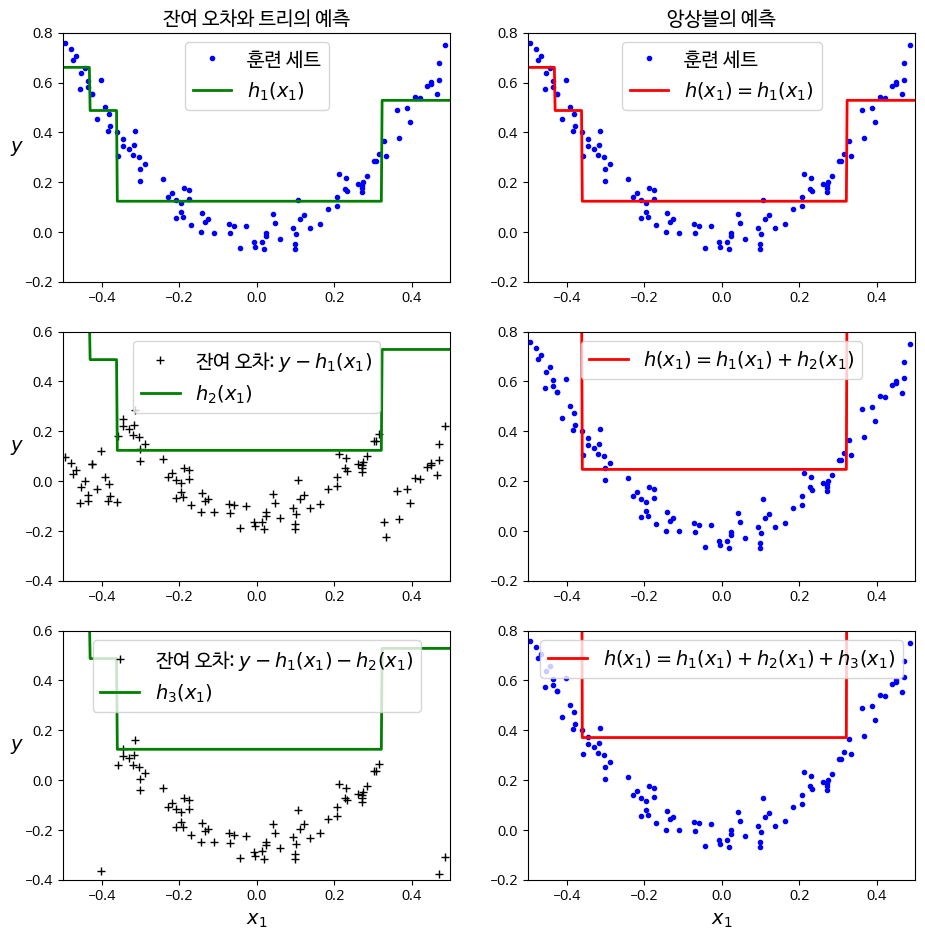

In [32]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

- 왼쪽 열 : 세 트리 예측
- 오른쪽 열 : 앙상블 예측

- 1번째 트리 : 트리와 앙상블 예측이 동일
  - 학습한 트리가 하나 뿐임

- 2번째 트리 : 두 개 트리의 예측 합과 동일
- 3번째 트리 : 앙상블 예측의 성능이 점점 좋아짐

ㅠ### 사이킷 런에서의 GBRT
- 클래스 : GradientBoostingRegressor
- 매개변수 : 트리의 성장을 제어하는 매개 변수
  - max_depth
  - min_samples_leaf
  - learning_rate : 트리의 기여도 (`축소(Shrinkage)`)
    - 낮을 수록 학습에 많은 트리 필요
    - 예측 성능 `상승`
    - 트리를 많이 사용 할 수록 과대 적합의 가능성이 상승
  - `n_iter_no_change` : 마지막 n개의 트리가 도움되지 않는 경우 조기종료
    - 너무 높으면 오히려 과대적합  가능성
  - `validation_fraction` : 검증세트 크기 제어 (기본 값 10%)
  - `subsample` : 각 트리를 훈련 할 때 사용하는 훈련 비율
    - `확률적 그레디언트 부스팅` 기법 가능

- 예시 : GBRT 학습

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, ### 트리 깊이
                                 n_estimators=3, ### 학습 횟수
                                 learning_rate=1.0, ### 학습률
                                 random_state=42)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- 예시 : learning_rate 차이


In [43]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)
gbrt_best.n_estimators_

92

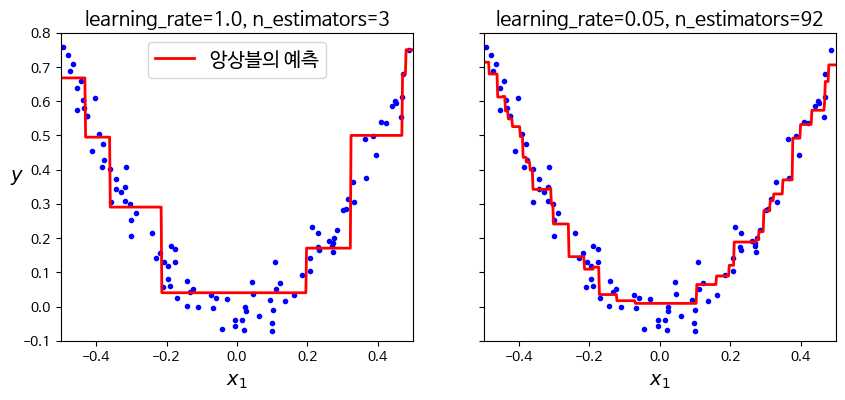

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="앙상블의 예측")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

- 예시 : `n_iter_no_change`를 통한 조기종료

In [45]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)
gbrt_best.n_estimators_

92

## 히스토그램 기반 그레디언트 부스팅
> 입력 특성을 구간으로 나누어 정수로 대체하는 방식
- `max_bins`를 통해 구간 값을 제어
  - 기본 값 : 255

### 장점
- 학습 알고리즘을 평가해야하는 가능한 임계값이 감소 -> `속도가 빠름`
- 특성 정렬할 필요 없음

### 단점
- 구간 분할 -> 규제로 작동 -> 정밀도 손실 유발 -> 과대적합 감소 혹은 과소적합 유발

### 계산 복잡도
$O(b \times m)$
    - b : 구간 개수
    - m : 훈련 샘플 개수
- HGB는 GBRT보다 빠르게 훈련 가능

### 사이킷런의 HGB
- HistGradientBoostingClassifier : 분류
- HistGradientBoostingRegressor : 회귀

#### GradientBoostingClassifier와의 차이
- 인스턴스 수가 10,000 이상이 되면 조기 종료 활성화
  - early_stopping 으로 제어 가능
- `subsample` 제공 X
- `n_estimators` -> `max_iter`
- 결정 트리 하이퍼 파라미터
  - `max_leaf_nodes`
  - `min_samples_leaf`
  - `max_depth`

- HGB 클래스는 범주형 특성과 누락값 지원

- 예시 : 캘리포니아 주택 데이터셋 훈련

In [52]:
from sklearn.pipeline import make_pipeline
import pandas as pd
import tarfile
import urllib.request
from pathlib import Path
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)


hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42))

hgb_reg.fit(housing,housing_labels)

C:\ProgramData\miniconda3\envs\ml_basic\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

# 6. 스태킹
> 앙상블에 속한 몯ㄴ 예측기의 예측을 취합하는 모델을 훈련
- `블랜더` 혹은 `메타 학습` : 예측 결과를 블렌더가 블렌딩

## 블랜더 훈련
- `블렌딩 훈련` : 블렌딩 훈련을 위해서는 훈련 세트 필요
  - `cross_val_predict()`를 사용 하여 표본 외 예측을 얻음
  - 해당 값을 블렌더 훈련을 위한 `입력특성`으로 이용
  - 특성 개수에 관계 없이 블렌딩 훈련세트에는 예측기당 하나의 입력 특성 포함
  - 블렌더 학습 후 전체 원본 훈련 세트로 재훈련

### 다중 스태킹
- 여러 블렌더를 훈련하여 전체 블렌더 계층을 얻음
- 마지막에 블렌더를 추가 -> 최종 예측 생성
- 장점 : 성능 상승
- 단점 : 훈련 시간 및 시스템 복잡성 상승

## 사이킷런에서 구현
- 클래스 : `StackingClassifier` , `StackingRegressor`

- 예시 :

In [55]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ("lr",LogisticRegression(random_state=42)),
        ("rf",RandomForestClassifier(random_state=42)),
        ("svc",SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5
)

stacking_clf.fit(X_train, y_train)

stacking_clf.score(X_test, y_test)

0.928